<a href="https://colab.research.google.com/github/matheus97eng/Bootcamp_Alura_2021/blob/main/notebooks/desenvolvimento_de_modelo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Apresentação

Esse é um dos notbooks do projeto final de bootcamp de DataScience da Alura (2021). A intenção do projeto é criar um modelo de machine learning capaz de prever, com um certo nível de confiança, se um paciente que chega ao hospital precisará ser futuramente internado ou não. **Este notebook vai focar somente na criação e validação do modelo que utilizará dados já preparados por [este notebook](https://colab.research.google.com/drive/13U-v251U06voBqKhnmTyj5ROGomGMWtF#scrollTo=FvBQwjN5SiMl).**



# Dados

Os dados são [deste repositório](https://github.com/matheus97eng/Bootcamp_Alura_2021/blob/main/projeto_final/data/clean_data_out.csv) e são resultado de uma análise exploratória feita por [este notebook](https://colab.research.google.com/drive/13U-v251U06voBqKhnmTyj5ROGomGMWtF#scrollTo=FvBQwjN5SiMl). Mas, originalmente os dados (não trabalhados para os modelos aplicados aqui) são do hospital Sírio Libanês, que os disponibilizou pelo [kaggle](https://www.kaggle.com/S%C3%ADrio-Libanes/covid19) com o objetivo de procurar um modelo que prevesse da melhor maneira possível se um paciente com entrada no hospital precisaria ser internado ou não na UTI.

Os dados foram modificados visando buscar as seguintes características:

- utilizar ao máximo os dados fornecidos pelo Sírio Libanês;
- não utilizar dados que foram retirados possivelmente depois do paciente ter sido internado;

In [1]:
import pandas as pd

data = pd.read_csv('https://github.com/matheus97eng/Bootcamp_Alura_2021/raw/main/projeto_final/data/clean_data_out.csv')
data.tail()

,PATIENT_VISIT_IDENTIFIER,Unnamed: 1,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,...,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU,WAS_ICU
289,380,1900,0,40th,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,-0.578947,-0.578947,-0.578947,-0.578947,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.293564,...,-1.0,-0.160494,-0.692308,0.339623,-0.457627,0.142857,0.736842,-0.160494,-0.692308,0.339623,-0.448276,0.142857,0.736842,0.030928,-0.375,0.401709,-0.357143,0.472527,0.898990,-0.418803,-0.783784,0.059701,-0.515152,-0.072464,0.736842,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,0-2,0,1
290,381,1905,1,Above 90th,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,...,-1.0,-0.407407,-0.692308,-0.283019,-0.457627,-0.059524,0.526316,-0.407407,-0.692308,-0.283019,-0.448276,-0.250000,0.526316,-0.175258,-0.375,-0.162393,-0.357143,0.230769,0.818182,-0.589744,-0.783784,-0.432836,-0.515152,0.072464,0.526316,-1.0,-1.0,-1.0,-1.0,-0.619048,-1.0,-1.0,-1.0,-1.0,-1.0,-0.612627,-1.0,0-2,0,0
291,382,1910,0,50th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,...,-1.0,0.012346,-0.384615,-0.320755,-0.457627,-0.071429,0.894737,0.012346,-0.384615,-0.320755,-0.448276,-0.071429,0.894737,0.175258,-0.125,-0.196581,-0.357143,0.340659,0.959596,-0.299145,-0.567568,-0.462687,-0.515152,-0.246377,0.894737,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,0-2,0,1
292,383,1915,0,40th,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,...,-1.0,0.086420,-0.230769,-0.301887,-0.661017,-0.107143,0.736842,0.086420,-0.230769,-0.301887,-0.655172,-0.107143,0.736842,0.237113,0.000,-0.179487,-0.571429,0.318681,0.898990,-0.247863,-0.459459,-0.447761,-0.696970,-0.275362,0.736842,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,0-2,0,0
293,384,1920,0,50th,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.717277,-0.717277,-0.717277,-0.717

Descrição das colunas:

`PATIENT_VISIT_IDENTIFIER` = identificador do paciente, de 0 a 384, correspondendo a 385 pacientes no total.

`AGE_ABOVE65` = 0 para pacientes menores de 65 anos e 1 para maiores de 65 anos.

`AGE_PERCENTIL` = faixa etária do paciente

`GENDER` = 0 para homens e 1 para mulheres

`DISEASE GROUPING 1` - `DISEASE GROUPING 6` e `HTN` = ausencia (valor 0) de determinada doença no paciente ou então presença (valor 1). HTN significa hipertenção. Os outros tipos de doença não foram revelados por questões de privacidade.

`IMMUNOCOMPROMISED` - o paciente está imunocomprometido? 0 para não e 1 para sim.

obs.: um paciente imunocomprometido é aquele que possui o sistema imunológico comprometido e que não consegue fazer a defesa que o organismo precisa fazer para a pessoa não ficar doente.

`OTHER` = não é deixado claro pelo hospital, mas possivelmente é a presença ou ausência de uma doença não listada.

`ALBUMIN_MEDIAN` - `OXYGEN_SATURATION_DIFF_REL` = informações sobre testes sanguíneos e informações vitais do paciente. São divididos entre as colunas:
- `MEAN` = média do valor obtido durante a janela
- `MEDIAN` = mediana do valor obtido durante a janela
- `MIN` = mínimo
- `MAX` = máximo
- `DIFF` = diferença entre máximo e mínimo
- `DIFF_REL` = valor de `DIFF` dividido pela mediana

`WINDOW` - janela representando qual período que o paciente ficou no hospital:
- '0-2' = nas primeiras 2 horas
- '2-4' = entre 2 a 4 horas
- '4-6' = entre 4 a 6 horas
- '6-12' = entre 6 a 12 horas
- 'ABOVE_12' = acima de 12 horas

`ICU` = coluna que fornece a informação se o paciente foi para UTI (valor 1) ou não foi (valor 1).

## Retirando colunas do dataframe

Para o desenvolvimento de um modelo de machine learning, quanto mais conseguimos reduzir informações que não contribuem muito para a predição, melhor será o resultado final. Um tratamento que já podemos fazer no dataframe sem precisar fazer nenhum tipo de análise estatística é remover colunas que contém o mesmo valor para todos os pacientes, por exemplo, a coluna `WINDOW`, que por conta do método utilizado para preparar os dados, contém somente o valor da primeira janela: '0-2'. A ideia é a seguinte: se todos os pacientes possuírem a mesma informação na coluna, ela não é válida para diferenciar os pacientes entre si e gerar uma informação útil na previsão para um novo paciente.

In [2]:
# lista das colunas que iremos eliminar:
for col in data.columns:
  if (len(data[col].unique()) < 2):
    print(col)

OTHER
ALBUMIN_DIFF
BE_ARTERIAL_DIFF
BE_VENOUS_DIFF
BIC_ARTERIAL_DIFF
BIC_VENOUS_DIFF
BILLIRUBIN_DIFF
BLAST_DIFF
CALCIUM_DIFF
CREATININ_DIFF
FFA_DIFF
GGT_DIFF
GLUCOSE_DIFF
HEMATOCRITE_DIFF
HEMOGLOBIN_DIFF
INR_DIFF
LACTATE_DIFF
LEUKOCYTES_DIFF
LINFOCITOS_DIFF
NEUTROPHILES_DIFF
P02_ARTERIAL_DIFF
P02_VENOUS_DIFF
PC02_ARTERIAL_DIFF
PC02_VENOUS_DIFF
PCR_DIFF
PH_ARTERIAL_DIFF
PH_VENOUS_DIFF
PLATELETS_DIFF
POTASSIUM_DIFF
SAT02_ARTERIAL_DIFF
SAT02_VENOUS_DIFF
SODIUM_DIFF
TGO_DIFF
TGP_DIFF
TTPA_DIFF
UREA_DIFF
DIMER_DIFF
WINDOW
ICU


In [3]:
def drop_unique_value(data, col):
  if (len(data[col].unique()) < 2):
    data.drop(col, axis=1, inplace=True)

for col in data.columns:
  drop_unique_value(data, col)

data.tail()

,PATIENT_VISIT_IDENTIFIER,Unnamed: 1,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,BILLIRUBIN_MAX,BLAST_MEDIAN,BLAST_MEAN,BLAST_MIN,...,DIMER_MEAN,DIMER_MIN,DIMER_MAX,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WAS_ICU
289,380,1900,0,40th,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.578947,-0.578947,-0.578947,-0.578947,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.293564,-0.293564,-0.293564,-0.293564,-1.0,-1.0,-1.0,...,-0.978029,-0.978029,-0.978029,-0.160494,-0.692308,0.339623,-0.457627,0.142857,0.736842,-0.160494,-0.692308,0.339623,-0.448276,0.142857,0.736842,0.030928,-0.375,0.401709,-0.357143,0.472527,0.898990,-0.418803,-0.783784,0.059701,-0.515152,-0.072464,0.736842,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,1
290,381,1905,1,Above 90th,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.938950,-0.938950,-0.938950,-0.938950,-1.0,-1.0,-1.0,...,-0.978029,-0.978029,-0.978029,-0.407407,-0.692308,-0.283019,-0.457627,-0.059524,0.526316,-0.407407,-0.692308,-0.283019,-0.448276,-0.250000,0.526316,-0.175258,-0.375,-0.162393,-0.357143,0.230769,0.818182,-0.589744,-0.783784,-0.432836,-0.515152,0.072464,0.526316,-1.0,-1.0,-1.0,-1.0,-0.619048,-1.0,-1.0,-1.0,-1.0,-1.0,-0.612627,-1.0,0
291,382,1910,0,50th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.938950,-0.938950,-0.938950,-0.938950,-1.0,-1.0,-1.0,...,-0.964461,-0.964461,-0.964461,0.012346,-0.384615,-0.320755,-0.457627,-0.071429,0.894737,0.012346,-0.384615,-0.320755,-0.448276,-0.071429,0.894737,0.175258,-0.125,-0.196581,-0.357143,0.340659,0.959596,-0.299145,-0.567568,-0.462687,-0.515152,-0.246377,0.894737,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,1
292,383,1915,0,40th,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.938950,-0.938950,-0.938950,-0.938950,-1.0,-1.0,-1.0,...,-0.978029,-0.978029,-0.978029,0.086420,-0.230769,-0.301887,-0.661017,-0.107143,0.736842,0.086420,-0.230769,-0.301887,-0.655172,-0.107143,0.736842,0.237113,0.000,-0.179487,-0.571429,0.318681,0.898990,-0.247863,-0.459459,-0.447761,-0.696970,-0.275362,0.736842,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,0
293,384,1920,0,5

Além disso, as colunas `PATIENT_VISIT_IDENTIFIER` e `Unnamed: 1` não fazem sentido nenhum serem usadas, são mais para identificação das linhas (`Unnamed: 1` era a identificação das linhas do dataframe original). Elas serão retiradas na função que roda os modelos.

## Tratando dados do tipo string

Modelos de machine learning em geral não aceitam dados do tipo string. Esse é o caso da coluna `AGE_PERCENTIL`.  Para tratarmos informações categóricas, podemos substituir as strings por números inteiros. Como o tipo da informação dá uma ideia de ordenação (de menor idade para maior), uma ordenação numérica representará bem esse tipo de informação. A troca dos dados será feita da seguinte maneira:

- '10th' = 0
- '20th' = 1
- '30th' = 2
- '40th' = 3
- '50th' = 4
- '60th' = 5
- '70th' = 6
- '80th' = 7
- '90th' = 8
- 'Above 90th' = 9

In [4]:
data['AGE_PERCENTIL'] = data['AGE_PERCENTIL'].astype("category").cat.codes
data.tail()

,PATIENT_VISIT_IDENTIFIER,Unnamed: 1,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,BILLIRUBIN_MAX,BLAST_MEDIAN,BLAST_MEAN,BLAST_MIN,...,DIMER_MEAN,DIMER_MIN,DIMER_MAX,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WAS_ICU
289,380,1900,0,3,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.578947,-0.578947,-0.578947,-0.578947,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.293564,-0.293564,-0.293564,-0.293564,-1.0,-1.0,-1.0,...,-0.978029,-0.978029,-0.978029,-0.160494,-0.692308,0.339623,-0.457627,0.142857,0.736842,-0.160494,-0.692308,0.339623,-0.448276,0.142857,0.736842,0.030928,-0.375,0.401709,-0.357143,0.472527,0.898990,-0.418803,-0.783784,0.059701,-0.515152,-0.072464,0.736842,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,1
290,381,1905,1,9,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.938950,-0.938950,-0.938950,-0.938950,-1.0,-1.0,-1.0,...,-0.978029,-0.978029,-0.978029,-0.407407,-0.692308,-0.283019,-0.457627,-0.059524,0.526316,-0.407407,-0.692308,-0.283019,-0.448276,-0.250000,0.526316,-0.175258,-0.375,-0.162393,-0.357143,0.230769,0.818182,-0.589744,-0.783784,-0.432836,-0.515152,0.072464,0.526316,-1.0,-1.0,-1.0,-1.0,-0.619048,-1.0,-1.0,-1.0,-1.0,-1.0,-0.612627,-1.0,0
291,382,1910,0,4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.938950,-0.938950,-0.938950,-0.938950,-1.0,-1.0,-1.0,...,-0.964461,-0.964461,-0.964461,0.012346,-0.384615,-0.320755,-0.457627,-0.071429,0.894737,0.012346,-0.384615,-0.320755,-0.448276,-0.071429,0.894737,0.175258,-0.125,-0.196581,-0.357143,0.340659,0.959596,-0.299145,-0.567568,-0.462687,-0.515152,-0.246377,0.894737,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,1
292,383,1915,0,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.938950,-0.938950,-0.938950,-0.938950,-1.0,-1.0,-1.0,...,-0.978029,-0.978029,-0.978029,0.086420,-0.230769,-0.301887,-0.661017,-0.107143,0.736842,0.086420,-0.230769,-0.301887,-0.655172,-0.107143,0.736842,0.237113,0.000,-0.179487,-0.571429,0.318681,0.898990,-0.247863,-0.459459,-0.447761,-0.696970,-0.275362,0.736842,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,0
293,384,1920,0,4,1,0.0,0.0,1.0,0.0

# MACHINE LEARNING

Agora vamos finalmente começar a construção do modelo! Vamos importar da biblioteca [sklearn](https://scikit-learn.org/stable/) alguns modelos e instanciá-los de maneira padrão. Destacamos que o problema a ser resolvido é um problema de **classificação binária** (o paciente precisará ou não ser internado?). Os modelos são:

- `model_dummy` = modelo simples que faz predições se baseando somente na proporção das classes dos dados de treinamento (no caso de `strategy='stratified'`).

- `model_rf` = modelo Random Forest. Esse método utiliza várias árvores de decisão para prever o resultado. A predição final será a classe que mais ocorreu nas predições entre as árvores de decisão. Uma árvore de decisão funciona separando por categorias as classes de acordo com as informações dos dados. A cada nó da árvore, mais separações são feitas, de modo que, quanto mais nós (ou níveis) uma árvore possui, melhor ela se ajusta aos dados que a treinam.

- `model_logistic` = modelo de regressão logística.

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier

# instanciando os modelos:
model_logistic = LogisticRegression(max_iter=10000)   #o número máximo de iterações precisou ser mudado porque o modelo pediu isso por meio de um Warning
model_dummy = DummyClassifier(strategy='stratified')
model_rf = RandomForestClassifier()

## Método de validação

Como métodos de validação dos modelos, utilizaremos a acurácia, a matriz de confusão e o AUC Score.

In [6]:
# importando métodos de validação:
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score

## Executando os primeiros modelos

Para rodar qualquer modelo, vamos seguir o mesmo procedimento com a função `make_cross_validation`:

1) Espalhar as linhas do dataframe para colher amostras aleatórias. Essa aleatoriedade porém será controlada por um `np.random.seed()` que manterá a reprodutibilidade dos resultados e comparação entre diferentes modelos.

2) Separar as variáveis x (features que determinam a predição) e y (o resultado que queremos prever).

3) Executar o método de validação cruzada, separando o dataframe em 5 partes. A validação cruzada será executado 10 vezes. Isso é para reduzir os efeitos da aleatoriedade.

4) Será calculado a média e o desvio padrão dos 10 scores obtidos (um para cada validação cruzada).

5) A função `make_cross_validation` retorna um print com a média do score junto com o intervalo de confiança (95%).

In [7]:
import numpy as np
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold

def make_cross_validation(model, data, n_splits, n_repeats, validate):

  # colocando a aleatoriedade
  np.random.seed(253)
  data = data.sample(frac=1).reset_index(drop=True)
  
  y = data['WAS_ICU']
  x = data.drop(['WAS_ICU', 'PATIENT_VISIT_IDENTIFIER', 'Unnamed: 1'], axis=1)

  cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)
  resultados = cross_validate(model, x, y, cv=cv, scoring=validate)

  mean = np.mean(resultados['test_score'])
  std = np.std(resultados['test_score'])
  print(f'Validação escolhida: {validate}')
  print(f'média = {mean}')
  text = 'O score está no intervalo entre {min:0.4f} e {max:0.4f}'
  print(text.format(min = mean - 2*std, max = mean + 2*std))

In [8]:
# verificando a acurácia do modelo dummy:
make_cross_validation(model_dummy, data, 5, 10, 'accuracy')

Validação escolhida: accuracy
média = 0.537469316189363
O score está no intervalo entre 0.4038 e 0.6712


Com uma acurácia muito baixa, fica claro que não é bom usar esse modelo. Mas ele pode servir de base como um nível mínimo de resultado esperado. Vamos agora executar modelos mais próprios para o tipo de problema que estamos tratando: a regressão logística e o random forest.

In [9]:
# acurácia do modelo de regressão logística:
make_cross_validation(model_logistic, data, 5, 10, 'accuracy')

Validação escolhida: accuracy
média = 0.7135359438924606
O score está no intervalo entre 0.5875 e 0.8396


In [10]:
# acurácia do modelo de random forest:
make_cross_validation(model_rf, data, 5, 10, 'accuracy')

Validação escolhida: accuracy
média = 0.7259322033898304
O score está no intervalo entre 0.6244 e 0.8274


## Matriz de confusão

Vamos analisar agora a matriz de confusão para ajudar a escolha do melhor modelo entre Random Forest e regressão logística.

A matriz de confusão funciona da seguinte maneira: horizontalmente ela representa a contagem de cada predição que o modelo fez. Lado esquerdo representa predição do paciente não ir para UTI e lado direito, predição de que o paciente deve ir. Na vertical está a contagem de dos valores reais do dataframe. A parte de cima representa aqueles que não foram para UTI e a parte de baixo representa os que foram.

Dessa maneira temos a contagem de 4 quadrantes diferentes:

- o primeiro representa a quantidade de pacientes que receberam previsão para não ir na UTI e realmente não foram nos dados de teste. O modelo acertou.

- o segundo representa a quantidade de pacientes que receberam previsão para ir na UTI, mas os dados de teste apontam que ele foi. O modelo errou.

- o terceiro representa a quantidade de pacientes que receberam previsão para não ir na UTI, mas os dados de teste apontam que ele não foi. O modelo errou.

- o último representa a quantidade de pacientes que receberam previsão para ir na UTI e realmente foram nos dados de teste. O modelo acertou.

In [11]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def confusion_matrix(model, data):

  # colocando a aleatoriedade
  np.random.seed(253)
  data = data.sample(frac=1).reset_index(drop=True)
  
  y = data['WAS_ICU']
  x = data.drop(['WAS_ICU', 'PATIENT_VISIT_IDENTIFIER', 'Unnamed: 1'], axis=1)
  x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)

  model.fit(x_train, y_train) # rodando o modelo
  plt.figure(figsize=(8,8))
  ax = plot_confusion_matrix(model_logistic, x_test, y_test)
  plt.xlabel('Predição', size=15)
  plt.ylabel('Valor real', size=15)

<Figure size 576x576 with 0 Axes>

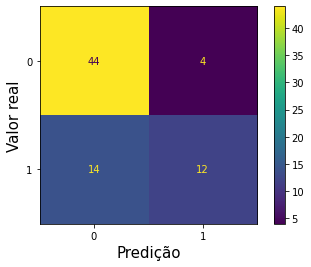

In [12]:
confusion_matrix(model_logistic, data)

<Figure size 576x576 with 0 Axes>

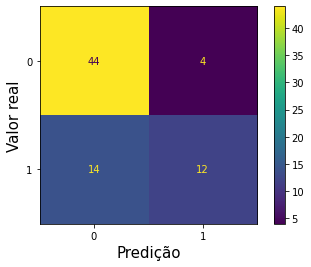

In [13]:
confusion_matrix(model_rf, data)

Antes de tirarmos conclusões, é importante lembrar que os dois modelos foram rodados somente uma vez com uma separação aleatória dos dados. Se houvesse outro tipo de separação, os resultados estariam diferentes. Isso torna a análise não muito confiável, pelo menos por enquanto. Mas a semente aleatória garante que os mesmos dados usados para teste na matriz de confusão do modelo Random Forest foram também usados para a matriz de confusão da regressão logística. Isso proporciona um bom comparativo entre os modelos, que aqui apresentaram o mesmo resultado.

Mas é importante entender o significado desses números. Ter uma alta quantidade no quadrante 2 significa que muitos pacientes podem ser diagnosticados precisando de UTI quando, na verdade, não precisariam. Isso é ruim pois um dos objetivos do hospital é justamente prever a locação de UTIs para que não haja sobrecarga da estrutura hospitalar. 

Por outro lado, uma alta quantidade no quadrante 3 também é ruim porque representa pacientes que precisariam ser internados, mas o modelo apontou como pacientes que não precisam. Mesmo que o hospital não utilizasse o modelo para determinar se um paciente deve ir ou não para a UTI, ele precisa contar com uma predição que prepare o hospital para receber os pacientes. O erro desse terceiro quadrante faria o Sírio Libanês esperar menos pacientes na UTI do que realmente ele deveria receber.

Claro que nenhum modelo é perfeito e, para ter um maior intervalo de segurança, é bom poder contar com o máximo de vagas na UTI possível. Pelo menos a princípio os dois tipos de erro do modelo devem ser minimizados o máximo possível.

## Melhorando o modelo Random Forest

O Random Forest foi o modelo que apresentou o melhor resultado comparado ao modelo de regressão logística. Além disso, ele possui hiperparâmetros fáceis de se identificar e que podem ser alterados, como o `n_estimators` e `max_depth`. O primeiro, diz quantas árvores de decisão serão utilizadas na previsão do esemble. O segundo determina a quantidade de nós que cada uma dessas árvores terá.

Aumentando esses 2 parâmetros, o resultado pode melhorar, mas há dois problemas:

- aumentar muito o `n_estimators` deixa o modelo muito lento, em troca de pouca melhoria na acurácia final calculada

- aumentar muito `max_depth` faz com que as árvores de decisão tenham muitos nós e haja overfit, quando o modelo se ajusta tanto aos dados de treino que não consegue mais fazer predições com outros tipos de dados.

Aqui vamos alterar os parâmetros para 300 árvores de decisão e 5 nós para cada árvore.

In [14]:
model_rf = RandomForestClassifier(n_estimators=300, max_depth=5)
make_cross_validation(model_rf, data, 5, 10, 'accuracy')

Validação escolhida: accuracy
média = 0.7305844535359439
O score está no intervalo entre 0.6539 e 0.8073


## Retirando features altamente correlacionadas entre si.

Colunas com dados altamente correlacionados entre si geralmente são as que causam problema de overfit. Na maior parte das vezes é mais vantajoso retirá-las, pois assim podemos ajustar os hiperparâmetros para obter uma maior acurácia, sem ocorrer problemas de over fit.

Vamos utilizar um método: features com uma correlação entre si maior que 0.95 serão, uma delas, eliminadas.

Não faz sentido, no entando, calcular correlação entre variáveis categóricas. Portanto vamos utilizar somente os dados de exame de sangue e sinais vitais.

In [15]:
def remove_corr_var(data, cut):
  matrix_corr = data.loc[:,'ALBUMIN_MEDIAN':'OXYGEN_SATURATION_DIFF_REL'].corr()
  matrix_upper = matrix_corr.where(np.triu(np.ones(matrix_corr.shape), k=1).astype(np.bool))
  exclude = [col for col in matrix_upper.columns if any(matrix_upper[col] > cut)]
  return data.drop(exclude, axis=1)

In [16]:
data_not_corr = remove_corr_var(data, 0.95)
data_not_corr.tail()

,PATIENT_VISIT_IDENTIFIER,Unnamed: 1,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,ALBUMIN_MEDIAN,BE_ARTERIAL_MEDIAN,BE_VENOUS_MEDIAN,BIC_ARTERIAL_MEDIAN,BIC_VENOUS_MEDIAN,BILLIRUBIN_MEDIAN,BLAST_MEDIAN,CALCIUM_MEDIAN,CREATININ_MEDIAN,FFA_MEDIAN,GGT_MEDIAN,GLUCOSE_MEDIAN,HEMATOCRITE_MEDIAN,INR_MEDIAN,LACTATE_MEDIAN,LEUKOCYTES_MEDIAN,LINFOCITOS_MEDIAN,P02_ARTERIAL_MEDIAN,P02_VENOUS_MEDIAN,PC02_ARTERIAL_MEDIAN,PC02_VENOUS_MEDIAN,PCR_MEDIAN,PH_ARTERIAL_MEDIAN,PH_VENOUS_MEDIAN,PLATELETS_MEDIAN,POTASSIUM_MEDIAN,SAT02_VENOUS_MEDIAN,SODIUM_MEDIAN,TGO_MEDIAN,TGP_MEDIAN,TTPA_MEDIAN,UREA_MEDIAN,DIMER_MEDIAN,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,OXYGEN_SATURATION_MIN,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,HEART_RATE_DIFF_REL,WAS_ICU
289,380,1900,0,3,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.578947,-1.0,-1.000000,-0.317073,-0.317073,-0.293564,-1.0,0.326531,-0.937721,1.000000,-0.147196,-0.824953,-0.253669,-0.806775,1.000000,-0.704519,-0.879668,-0.170732,-0.704142,-0.77931,-0.754601,-0.565974,0.234043,0.363636,-0.895861,-0.629630,0.345679,-0.428571,-0.925725,-0.981326,-0.629428,-0.860241,-0.978029,-0.160494,-0.692308,0.339623,-0.457627,0.142857,0.736842,0.898990,0.736842,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,1
290,381,1905,1,9,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-1.000000,-0.317073,-0.317073,-0.938950,-1.0,0.285714,-0.886766,-0.742004,-0.958528,-0.891993,-0.241090,-0.959849,1.000000,-0.794129,-0.921162,-0.170732,-0.704142,-0.77931,-0.754601,-0.993195,0.234043,0.363636,-0.516689,-0.518519,0.345679,-0.314286,-0.998507,-0.995808,-0.846633,-0.855422,-0.978029,-0.407407,-0.692308,-0.283019,-0.457627,-0.059524,0.526316,0.818182,0.526316,-1.0,-1.0,-1.0,-1.0,-0.619048,-1.0,-1.0,0
291,382,1910,0,4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.605263,-1.0,-1.000000,-0.317073,-0.317073,-0.938950,-1.0,0.357143,-0.905166,-0.742004,-0.958528,-0.891993,0.064990,-0.959849,1.000000,-0.718038,-0.838174,-0.170732,-0.704142,-0.77931,-0.754601,-0.034405,0.234043,0.363636,-0.658211,-0.407407,0.345679,-0.085714,-0.995428,-0.986662,-0.846633,-0.787952,-0.964461,0.012346,-0.384615,-0.320755,-0.457627,-0.071429,0.894737,0.959596,0.894737,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,1
292,383,1915,0,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.605263,-1.0,-1.000000,-0.317073,-0.317073,-0.938950,-1.0,0.357143,-0.922151,-0.742004,-0.958528,-0.843575,-0.069182,-0.959849,1.000000,-0.877559,-0.819502,-0.170732,-0.704142,-0.77931,-0.754601,-0.804159,0.234043,0.363636,-0.623498,-0.555556,0.345679,0.085714,-0.995428,-0.986662,-0.846633,-0.937349,-0.978029,0.086420,-0.230769,-0.301887,-0.661017,-0.107143,0.736842,0.898990,0.736842,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,0
293,384,1920,0,4,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.605263,-1.0,-0.717277,-0.317073,-0.170732,-0.982208,-1.0,0.244898,-0.934890,-0.782516,-0.960280,-0.862197,-0.064990,-0.957340,-0.897773,-0.848590,-0.686722,-0.170732,-0.857988,-0.77931,-0.730061,-0.906238,0.234043,0.424242,-0.479306,-0.333333,-0.333333,-0.085714,-0.997387,-0.992378,-0.869210,-0.879518,-0.979571,0.012346,-0.292308,0.056604,-0.525424,0.535714,0.789474,0.919192,0.789474,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,0


In [17]:
data_not_corr.shape

(294, 62)

Veja que antes tínhamos 194 colunas de dados e agora temos 62 colunas. Na verdade, 59 das colunas serão utilizadas para os dados de treino.

Vamos rodar o modelo uma penúltima vez e verificar a acurácia.

In [18]:
model_rf = RandomForestClassifier(n_estimators=300, max_depth=5)
make_cross_validation(model_rf, data_not_corr, 5, 10, 'accuracy')

Validação escolhida: accuracy
média = 0.7080771478667447
O score está no intervalo entre 0.6190 e 0.7972


Verificamos agora que a acurácia diminuiu! Mas podemos tentar aumentar o número de nós:

In [19]:
for n in range(5,15):
  print('Número de nós:', n)
  model_rf = RandomForestClassifier(n_estimators=300, max_depth=n)
  make_cross_validation(model_rf, data_not_corr, 5, 10, 'accuracy')

Número de nós: 5
Validação escolhida: accuracy
média = 0.7080771478667447
O score está no intervalo entre 0.6190 e 0.7972
Número de nós: 6
Validação escolhida: accuracy
média = 0.7104441846873175
O score está no intervalo entre 0.6124 e 0.8085
Número de nós: 7
Validação escolhida: accuracy
média = 0.7104675628287553
O score está no intervalo entre 0.6203 e 0.8006
Número de nós: 8
Validação escolhida: accuracy
média = 0.7094330800701343
O score está no intervalo entre 0.6145 e 0.8043
Número de nós: 9
Validação escolhida: accuracy
média = 0.7118293395675042
O score está no intervalo entre 0.6093 e 0.8144
Número de nós: 10
Validação escolhida: accuracy
média = 0.7132144944476915
O score está no intervalo entre 0.6224 e 0.8041
Número de nós: 11
Validação escolhida: accuracy
média = 0.7176271186440678
O score está no intervalo entre 0.6268 e 0.8085
Número de nós: 12
Validação escolhida: accuracy
média = 0.7142314436002337
O score está no intervalo entre 0.6257 e 0.8028
Número de nós: 13
Val

observamos que mesmo aumentando muito o número de nós, as mudanças na acurácia não são significativas e a partir do número 12 a acurácia passou a diminuir com o aumento do número de nós.

Para a proposta e pelo o que foi feito até aqui, é melhor manter o número de colunas de antes.